In [1]:
import numpy as np
import pandas as pd
import pathlib
import requests
import scanpy as sc
import seaborn as sns
import scvi

/home/victor/anaconda3/envs/rna/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/victor/anaconda3/envs/rna/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/victor/anaconda3/envs/rna/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
SAMPLE_RAW_DATA_PATH = DATA_DIR / 'raw_data' / 'GSM5226574_C51ctr_raw_counts.csv.gz'

In [3]:
adata = sc.read_csv(SAMPLE_RAW_DATA_PATH).T
adata

AnnData object with n_obs × n_vars = 6099 × 34546

## Doublet removal

In [4]:
# Filter genes expressed in less than 10 cells
sc.pp.filter_genes(adata, min_cells=10)

In [5]:
# Keep only top 2000 highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor='seurat_v3')

In [6]:
scvi.model.SCVI.setup_anndata(adata)
model = scvi.model.SCVI(adata)
model.train()

/home/victor/anaconda3/envs/rna/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [02:31<00:00,  2.64it/s, v_num=1, train_loss_step=345, train_loss_epoch=322]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:31<00:00,  2.65it/s, v_num=1, train_loss_step=345, train_loss_epoch=322]


In [7]:
solo = scvi.external.SOLO.from_scvi_model(model, adata)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/400:  75%|███████▌  | 300/400 [01:15<00:25,  3.98it/s, v_num=1, train_loss_step=0.273, train_loss_epoch=0.297]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.267. Signaling Trainer to stop.


In [8]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)

df

,doublet,singlet,prediction
TAGGTACCATGGCCAC-1_1,1.270193,-2.842817,doublet
ATTCACTGTAACAGGC-1_1,0.629768,-1.794621,doublet
TAACTTCCAACCACGC-1_1,-0.640146,-0.519895,singlet
TTGGGTACACGACAAG-1_1,0.144315,-1.863139,doublet
AGGCCACAGAGTCACG-1_1,0.485670,-1.549205,doublet
...,...,...,...
CGCCATTGTTTGCCGG-1_1,-2.402599,1.484210,singlet
CACTGGGGTCTACGTA-1_1,-4.307249,3.702875,singlet
CATACTTGTAGAGGAA-1_1,-3.110165,2.064673,singlet
TTTGGTTTCCACGGAC-1_1,-4.035552,3.361327,singlet


In [9]:
df.groupby('prediction').count()

,doublet,singlet
prediction,,
doublet,1337,1337
singlet,4762,4762


In [10]:
df['dif'] = df.doublet - df.singlet
df

,doublet,singlet,prediction,dif
TAGGTACCATGGCCAC-1_1,1.270193,-2.842817,doublet,4.113010
ATTCACTGTAACAGGC-1_1,0.629768,-1.794621,doublet,2.424389
TAACTTCCAACCACGC-1_1,-0.640146,-0.519895,singlet,-0.120251
TTGGGTACACGACAAG-1_1,0.144315,-1.863139,doublet,2.007454
AGGCCACAGAGTCACG-1_1,0.485670,-1.549205,doublet,2.034874
...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,-2.402599,1.484210,singlet,-3.886808
CACTGGGGTCTACGTA-1_1,-4.307249,3.702875,singlet,-8.010124
CATACTTGTAGAGGAA-1_1,-3.110165,2.064673,singlet,-5.174838
TTTGGTTTCCACGGAC-1_1,-4.035552,3.361327,singlet,-7.396879


/home/victor/anaconda3/envs/rna/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


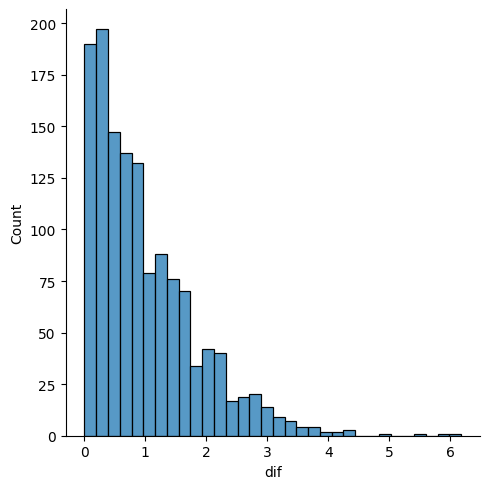

In [11]:
sns.displot(df[df.prediction == 'doublet'], x = 'dif')

In [12]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
doublets

,doublet,singlet,prediction,dif
TAGGTACCATGGCCAC-1_1,1.270193,-2.842817,doublet,4.113010
ATTCACTGTAACAGGC-1_1,0.629768,-1.794621,doublet,2.424389
TTGGGTACACGACAAG-1_1,0.144315,-1.863139,doublet,2.007454
AGGCCACAGAGTCACG-1_1,0.485670,-1.549205,doublet,2.034874
CACTGAAGTCGAAGCA-1_1,0.360243,-1.508410,doublet,1.868654
...,...,...,...,...
CAATACGCAATGTGGG-1_1,0.011323,-1.001105,doublet,1.012428
GTTAGTGGTTCGGTTA-1_1,0.105330,-0.910131,doublet,1.015462
ATCAGGTGTCGTCTCT-1_1,0.737757,-1.551342,doublet,2.289099
GGAGGTAGTTAAGCAA-1_1,0.376518,-0.927058,doublet,1.303576


In [13]:
adata = sc.read_csv(SAMPLE_RAW_DATA_PATH).T
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [14]:
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)

In [15]:
adata.obs

,doublet
TAGGTACCATGGCCAC-1_1,True
ATTCACTGTAACAGGC-1_1,True
TAACTTCCAACCACGC-1_1,False
TTGGGTACACGACAAG-1_1,True
AGGCCACAGAGTCACG-1_1,True
...,...
CGCCATTGTTTGCCGG-1_1,False
CACTGGGGTCTACGTA-1_1,False
CATACTTGTAGAGGAA-1_1,False
TTTGGTTTCCACGGAC-1_1,False


In [16]:
adata = adata[~adata.obs.doublet]

In [17]:
adata

View of AnnData object with n_obs × n_vars = 5582 × 34546
    obs: 'doublet'

## Preprocessing

In [18]:
adata.var['mt'] = adata.var.index.str.startswith('MT-')

/tmp/ipykernel_10220/310233584.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var.index.str.startswith('MT-')


In [19]:
response = requests.get('https://www.gsea-msigdb.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=json').json()
ribo_genes = response["KEGG_RIBOSOME"]['geneSymbols']

ribo_genes = np.array(ribo_genes)

In [20]:
adata.var['ribo'] = adata.var.index.isin(ribo_genes)

In [21]:
adata.var[adata.var.ribo == True]

,mt,ribo
RPL22,False,True
RPL11,False,True
RPS8,False,True
RPL5,False,True
RPS27,False,True
...,...,...
RPS4X,False,True
RPL36A,False,True
RPL39,False,True
RPL10,False,True


In [22]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

In [23]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TAACTTCCAACCACGC-1_1,False,5158,15645.0,221.0,1.412592,211.0,1.348674
TTGGTTTTCCTAGCTC-1_1,False,3902,11472.0,463.0,4.035913,13.0,0.113319
CGCATAACATGCCGGT-1_1,False,3745,8617.0,119.0,1.380991,25.0,0.290124
TCTATCACAAGGCTTT-1_1,False,3582,8276.0,183.0,2.211213,5.0,0.060416
ATCCACCAGAGGTATT-1_1,False,3913,8286.0,191.0,2.305093,34.0,0.410331
...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827


In [24]:
adata.var.sort_values('n_cells_by_counts')

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL445072.1,False,False,0,0.000000,100.000000,0.0
AC025614.2,False,False,0,0.000000,100.000000,0.0
LINC02022,False,False,0,0.000000,100.000000,0.0
AC090952.1,False,False,0,0.000000,100.000000,0.0
AC090644.1,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...
AKAP13,False,False,3998,2.828914,28.376926,15791.0
NEAT1,False,False,4075,4.852203,26.997492,27085.0
MBNL1,False,False,4094,2.645109,26.657112,14765.0
ZBTB20,False,False,4212,2.377284,24.543174,13270.0


In [25]:
sc.pp.filter_genes(adata, min_cells=3)

In [26]:
adata.obs.sort_values('total_counts')

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
CTCAACCGTTTGGGAG-1_1,False,325,401.0,0.0,0.000000,0.0,0.000000
TGGTACAGTTGGTGTT-1_1,False,323,401.0,0.0,0.000000,0.0,0.000000
AGGCATTCATCCGTTC-1_1,False,290,401.0,1.0,0.249377,0.0,0.000000
GTCGTTCTCCAAGGGA-1_1,False,300,401.0,0.0,0.000000,0.0,0.000000
CGAGAAGGTGAACTAA-1_1,False,308,401.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
TCTATCACAAGGCTTT-1_1,False,3582,8276.0,183.0,2.211213,5.0,0.060416
ATCCACCAGAGGTATT-1_1,False,3913,8286.0,191.0,2.305093,34.0,0.410331
CGCATAACATGCCGGT-1_1,False,3745,8617.0,119.0,1.380991,25.0,0.290124
TTGGTTTTCCTAGCTC-1_1,False,3902,11472.0,463.0,4.035913,13.0,0.113319


/home/victor/anaconda3/envs/rna/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


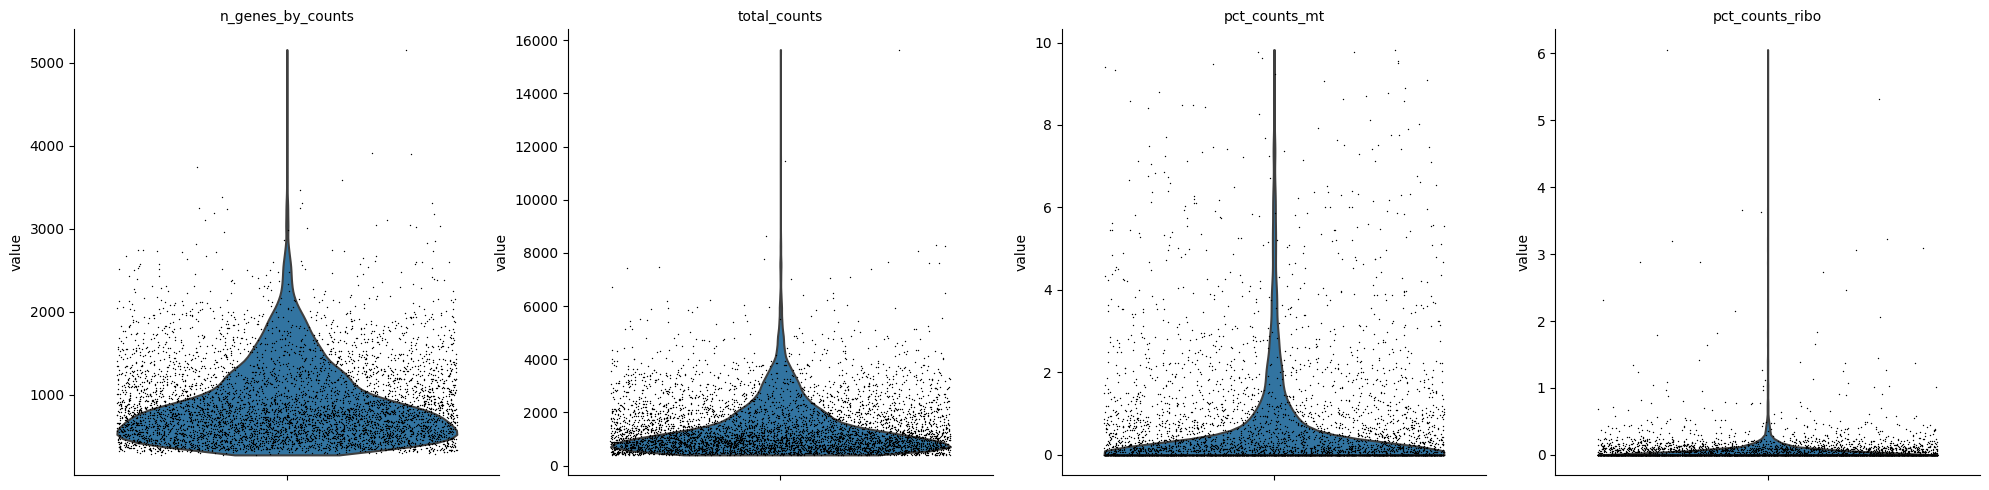

In [27]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], jitter=0.4, multi_panel=True)

In [29]:
upper_lim = np.quantile(adata.obs.n_genes_by_counts, .98)
adata = adata[adata.obs.n_genes_by_counts < upper_lim]
adata = adata[adata.obs.pct_counts_mt < 20]
adata = adata[adata.obs.pct_counts_ribo < 2]
adata

View of AnnData object with n_obs × n_vars = 5455 × 23985
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

## Normalization

In [31]:
adata.X.sum(axis = 1)

array([5250., 4877., 4783., ...,  410.,  405.,  410.], dtype=float32)

In [33]:
sc.pp.normalize_total(adata, target_sum=1e4)
adata.X.sum(axis = 1)

array([10000., 10000., 10000., ..., 10000., 10000., 10000.], dtype=float32)

In [34]:
sc.pp.log1p(adata) # change to log counts
adata.X.sum(axis = 1)

array([2858.1602, 3131.0637, 3076.6455, ..., 1191.2706, 1022.7511,
       1162.8784], dtype=float32)

In [35]:
adata.raw = adata